In [190]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

In [191]:
batch_size = 512

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [192]:
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.fc1 = nn.Linear(32 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x
  
model = CNNModel()
model = model.to(device)

In [193]:
def get_train_step(model, loss_fn, optimizer):
  def train_step(x, y):
    yhat = model(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
  return train_step

def evaluate():
  total = 0
  correct = 0
  for i, (x, y) in enumerate(testloader):
    x = x.to(device)
    y = y.to(device) 
    yhat = model(x)
    _, prediction = torch.max(yhat, dim=1)
    total += y.shape[0]
    correct += (prediction == y).sum()

  accuracy = 100 * correct / total
  print(f'Accuracy: {accuracy}%')


15.864444732666016


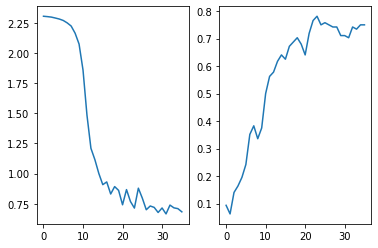

In [194]:
lr = 0.005
momentum = 0.9

# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()


epochs = 3

loss = 0.0

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_step = get_train_step(model, loss_fn, optimizer)
losses = []
accuracies = []
itertestloader = iter(testloader)
t = time.time()

counter = 0
for epoch in range(epochs):
  # train
  model.train()
  for i, (x, y) in enumerate(trainloader):
    x = x.to(device)
    y = y.to(device)
    loss = train_step(x, y)

    if i % 10 == 0:
      losses.append(loss)
  
    if i % 10 == 0:
      # eval
      model.eval()
      total = 0
      correct = 0

      x, y = next(itertestloader)
      x = x.to(device)
      y = y.to(device) 
      yhat = model(x)
      _, prediction = torch.max(yhat, dim=1)
      total += y.shape[0]
      correct += (prediction == y).sum().item()
      accuracy = correct / total
      accuracies.append(accuracy)

    counter += 1

fig, axs = plt.subplots(1, 2)
axs[0].plot(losses)
axs[1].plot(accuracies)
  




# with torch.no_grad(): evaluate()

t = time.time() - t
print(t)

